## Download all O3a data

In [1]:
import urllib.request, json, os
with urllib.request.urlopen("https://www.gw-openscience.org/archive/links/O3a_4KHZ_R1/L1/1238166018/1253977218/json/") as url:
    data = json.loads(url.read().decode())

In [2]:
with open('ligo_o3a_data.json','w') as f:
    json.dump(data,f)

In [6]:
dpath = './data/' # download directory

with open('ligo_o3a_data.json','r') as f:
	d = json.load( f)

	strain = []
	for s in d['strain']:
		if '.hdf5' in s['url']:
			path = dpath+s['url'].split('/')[-1]
			if not os.path.isfile(path):
				strain.append( dict( url=s['url'], path=path))

print( strain[0])

{'url': 'https://www.gw-openscience.org/archive/data/O3a_4KHZ_R1/1237319680/L-L1_GWOSC_O3a_4KHZ_R1-1238171648-4096.hdf5', 'path': './data/L-L1_GWOSC_O3a_4KHZ_R1-1238171648-4096.hdf5'}


In [8]:
import requests

def url_download( s):
	r = requests.get( s['url'], stream=True)
	with open( s['path'], 'wb') as f:
		for ch in r:
			f.write(ch)

if not os.path.isdir(dpath):
    os.mkdir(dpath)

for st in strain: # download all data
    url_download( st)


In [9]:
from os import listdir
from os.path import isfile, join
f_list = [f for f in listdir(dpath) if isfile(join(dpath, f))]
print(len(f_list))
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm.notebook import tqdm, trange


3


In [17]:
from gwpy.timeseries import TimeSeries

length = 32 # psd segment

psd_arr = []
for f in tqdm(f_list):
    data = TimeSeries.read(dpath+f, format="hdf5.losc")
    t0 = np.float(data.t0.value)
    while t0+length < data.t0.value+data.duration.value:
        seg = data.crop(start=t0,end=t0+length,copy=True)
        t0 += length
        if any(np.isnan(seg)):
            continue
        psd = seg.psd(fftlength=1)
        psd_arr.append(psd)

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_48143/3593196305.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  t0 = np.float(data.t0.value)


In [18]:
import pickle
with open('psd_o3a_32sec.pkl','wb') as f:
    pickle.dump( psd_arr, f)

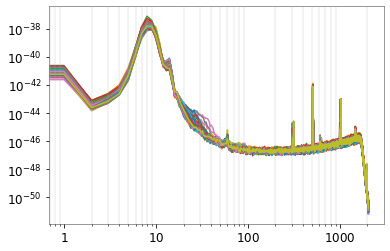

In [19]:
for psd in psd_arr:
    plt.loglog(psd)
plt.grid()
plt.grid(which='minor',linewidth=.3)
plt.show()